# Data Preprocessing

Importing necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from datetime import datetime
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
%matplotlib inline
!pip install pmdarima --quiet
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

Loading the dataset

In [ ]:
data = pd.read_csv('/content/AirPassengers.csv')
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format = True)
data = data.rename(columns={'#Passengers': 'Passengers'})
data = data.set_index(['Month'])

data.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

In [ ]:
data.shape

(144, 1)

In [ ]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


In [ ]:
print(data.describe())

       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


In [ ]:
# from matplotlib.pylab import rcParams
# plt.rcParams ['figure.figsize'] = (12, 5)
# plt.rcParams ['axes.grid'] = 'False'
# plt.rcParams ['font.size'] = 10
# plt.rcParams ['font.style'] = 'normal'

# Plotting the Airline timeseries plot

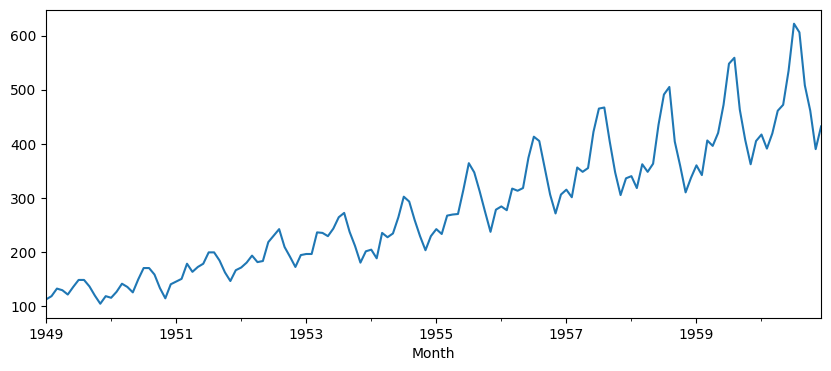

In [ ]:
plt.figure(figsize = (10, 4))
data['Passengers'].plot();

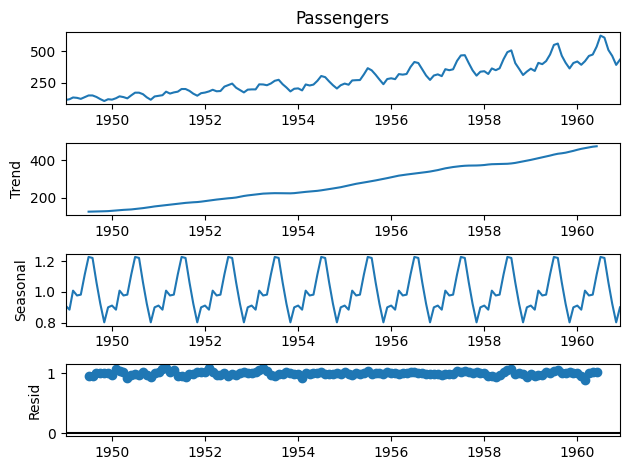

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data['Passengers'],
                                          period = 12,
                                          model = 'multiplicative').plot()
plt.show()

# **5 Ways To make the Data Stationary**

In [ ]:
# 1) log transformation
# 2) subtracting simple moving average
# 3) subtractiong eponential moving average
# 4) subtracting from previous value (shift)
# 5) seasonal decomposition

**Stationarity Check using Augmented Dicky Fuller test Statistics and Calculation of Rolling Mean and Rolling Standard Deviation**

In [ ]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_stationarity(transformed_data, window_size=12, alpha=0.05):

    # Calculate moving statistics
    rolling_mean = transformed_data.rolling(window=window_size).mean()
    rolling_std = transformed_data.rolling(window=window_size).std()


    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(transformed_data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

    # Check the stationarity based on the p-value
    if dftest[1] < alpha:
        print('Reject the null hypothesis. The data is stationary.')
        print('------------------------------------------------------------')
        # return True
    else:
        print('Fail to reject the null hypothesis. The data is non-stationary.')
        print('-------------------------------------------------------------------')

    # Plot the moving statistics

    plt.figure(figsize=(10, 4))
    plt.plot(transformed_data, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean', color = 'red')
    plt.plot(rolling_std, label='Rolling Std', color = 'black')
    plt.legend()
    plt.title('Moving Statistics')
    plt.xlabel('Time')
    plt.ylabel('No of Passengers')
    plt.show()

    # return False


# 1) Log Transformatiom

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Fail to reject the null hypothesis. The data is non-stationary.
-------------------------------------------------------------------


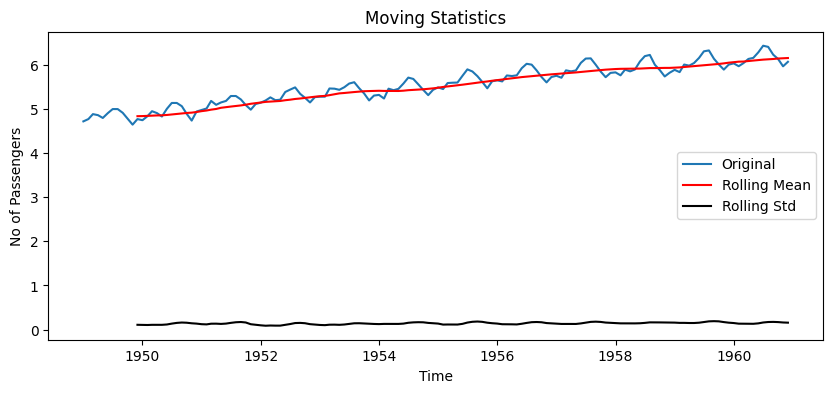

In [ ]:
# Load the time series data into a pandas Series
data1 = data['Passengers']

# Apply log transformation to the data
log_data = np.log(data1)

# Perform stationarity check on the log-transformed data
check_stationarity(log_data)

# 2) Subtracting Simple Moving Average


In [ ]:
# Finding moving average of the log tranformed dataset and then
# subtracting it from the log tranformed values
print('Value after subtracting the moving average from og scaled data')
print('---------------------------------------------------------------')
log_data_moving_avg = log_data.rolling(12).mean()
log_data_difference = log_data - log_data_moving_avg
print(log_data_difference)

Value after subtracting the moving average from og scaled data
---------------------------------------------------------------
Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
                ...   
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789
Name: Passengers, Length: 144, dtype: float64


In [ ]:
#Removing Nan or NULL values for performing ADF test.
log_data_difference.dropna(inplace = True)
print(log_data_difference)

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
                ...   
1960-08-01    0.282363
1960-09-01    0.098235
1960-10-01   -0.009230
1960-11-01   -0.182690
1960-12-01   -0.085789
Name: Passengers, Length: 133, dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


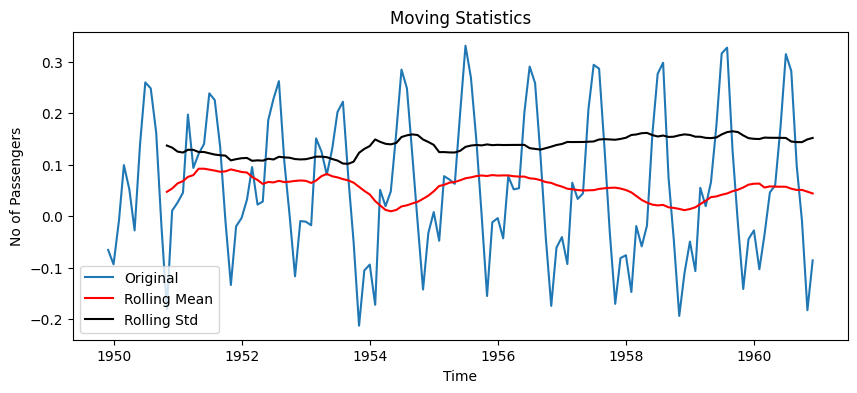

In [ ]:
# Now performing stationarity check of the differenced log data.
check_stationarity(log_data_difference)

# 3) Differencing Exponential Moving Average

In [ ]:
# Apply exponential moving average
log_data_ema = log_data.ewm(halflife = 12, min_periods = 0, adjust = True).mean()
print('')
print('Exponential moving average values')
print('------------------------------------')
print(log_data_ema)


Exponential moving average values
------------------------------------
Month
1949-01-01    4.718499
1949-02-01    4.745345
1949-03-01    4.793835
1949-04-01    4.811785
1949-05-01    4.808206
                ...   
1960-08-01    6.046445
1960-09-01    6.056778
1960-10-01    6.061079
1960-11-01    6.055750
1960-12-01    6.056461
Name: Passengers, Length: 144, dtype: float64


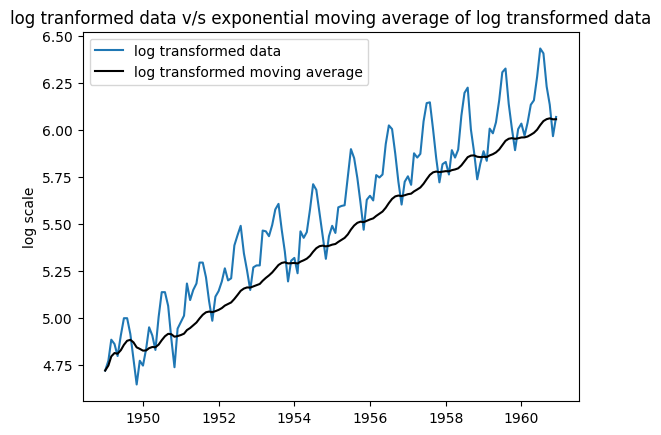

In [ ]:
# log tranformed data v/s exponential moving average of log transformed data
plt.plot(log_data, label = 'log transformed data')
plt.plot(log_data_ema, color = 'black', label = 'log transformed moving average')
plt.ylabel('log scale')
plt.title('log tranformed data v/s exponential moving average of log transformed data')
plt.legend()
plt.show()

In [ ]:
# Subtracting the expoential moving average from the log transformed values
log_data_ema_diff = log_data - log_data_ema
print('Differenced exponential moving average values')
print('------------------------------------------------')
print(log_data_ema_diff)

Differenced exponential moving average values
------------------------------------------------
Month
1949-01-01    0.000000
1949-02-01    0.025339
1949-03-01    0.088967
1949-04-01    0.048028
1949-05-01   -0.012415
                ...   
1960-08-01    0.360435
1960-09-01    0.173704
1960-10-01    0.072319
1960-11-01   -0.089603
1960-12-01    0.011964
Name: Passengers, Length: 144, dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


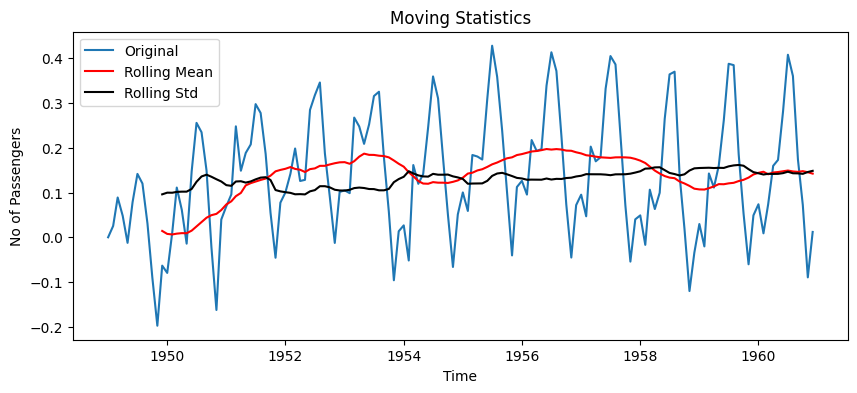

In [ ]:
# Now performing stationarity check of the differenced exponential moving average.
check_stationarity(log_data_ema_diff)

# 4) Subtracting from previous value (shift)



In [ ]:
#Subtractng the adjacent log scale values of the data
log_data_shift = log_data - log_data.shift()
log_data_shift.dropna(inplace = True)
print('')
print('Shifted log values')
print('-------------------')
print('')
print(log_data_shift)


Shifted log values
-------------------

Month
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
1949-06-01    0.109484
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Name: Passengers, Length: 143, dtype: float64


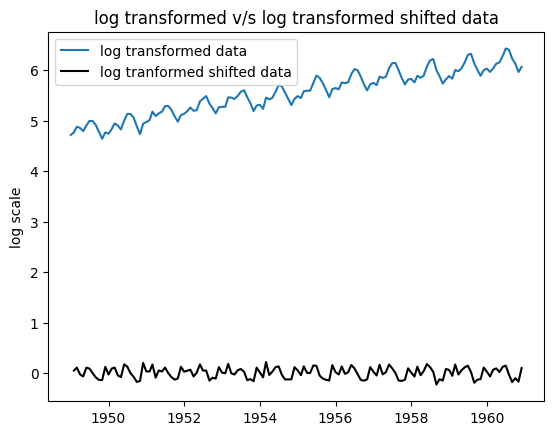

In [ ]:
# Visualising shifted data

plt.plot(log_data, label = 'log transformed data')
plt.plot(log_data_shift, label = 'log tranformed shifted data', color = 'black')
plt.title('log transformed v/s log transformed shifted data')
plt.ylabel('log scale')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
Fail to reject the null hypothesis. The data is non-stationary.
-------------------------------------------------------------------


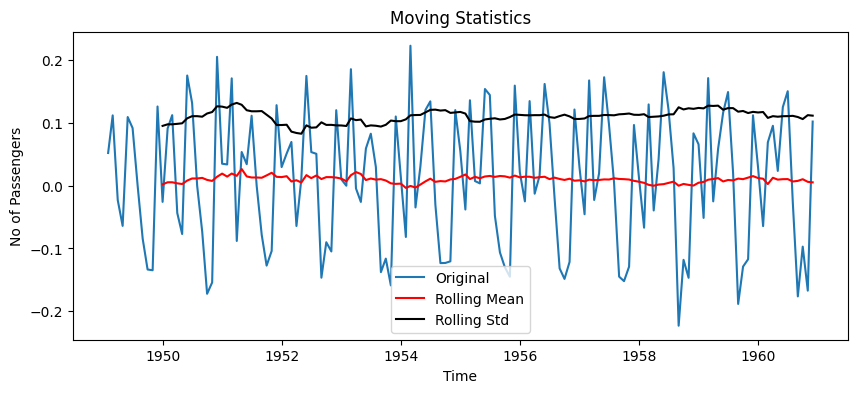

In [ ]:
# Now performing stationarity check of the log transformed shifted data
check_stationarity(log_data_shift)

In [ ]:
# Since the p value is sightly high from
# the threshold we can make the p value by shifting and subtracting previous 2 values.

log_data_shift2 = log_data - log_data.shift(2)
log_data_shift2.dropna(inplace = True)
print('')
print('Shifted log values')
print('-------------------')
print('')
print(log_data_shift2)


Shifted log values
-------------------

Month
1949-03-01    0.164303
1949-04-01    0.089128
1949-05-01   -0.087011
1949-06-01    0.045462
1949-07-01    0.201422
                ...   
1960-08-01    0.124613
1960-09-01   -0.202459
1960-10-01   -0.273482
1960-11-01   -0.264335
1960-12-01   -0.064972
Name: Passengers, Length: 142, dtype: float64


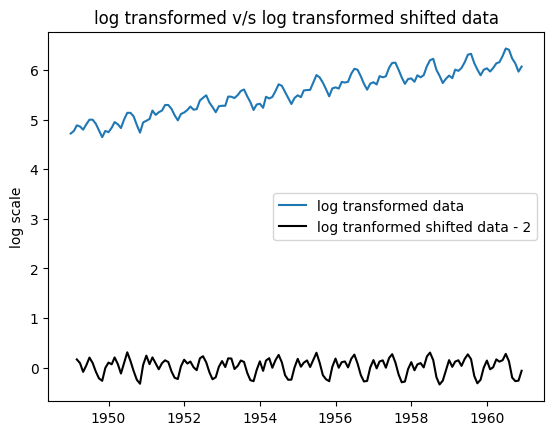

In [ ]:
# Visualising shifted data

plt.plot(log_data, label = 'log transformed data')
plt.plot(log_data_shift2, label = 'log tranformed shifted data - 2', color = 'black')
plt.title('log transformed v/s log transformed shifted data')
plt.ylabel('log scale')
plt.legend()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


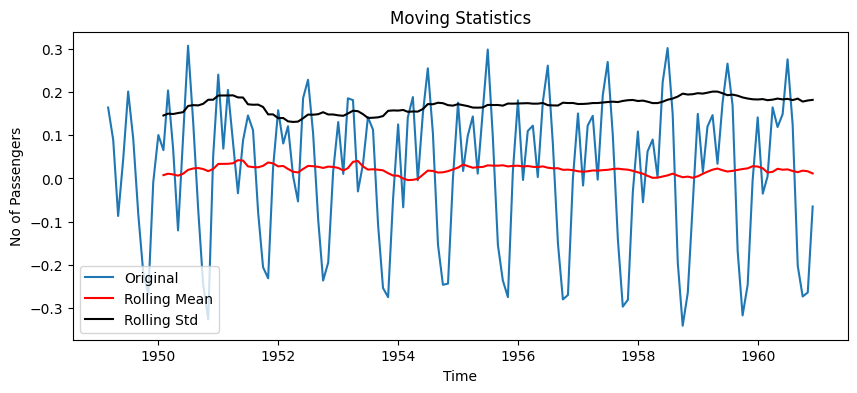

In [ ]:
# Now performing stationarity check of the log transformed shifted data
check_stationarity(log_data_shift2)

# 5) Seasonal Decomposition

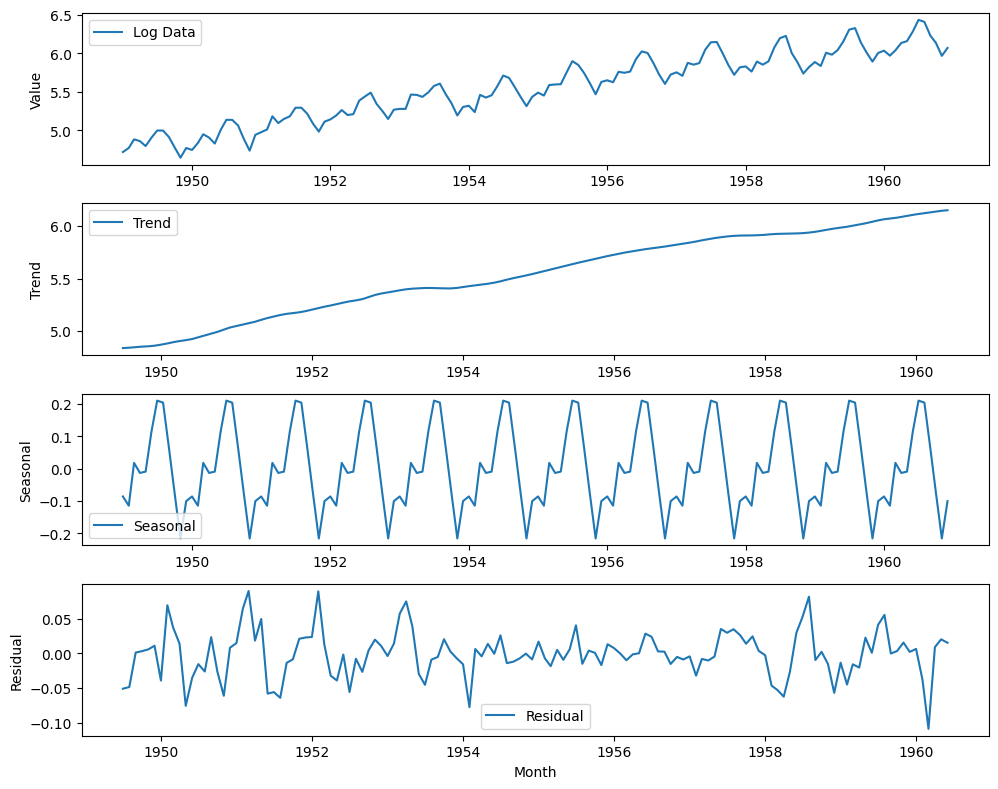

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Apply log transformation to the data
log_data = np.log(data['Passengers'])

# Decompose the log-transformed data
decomposition = seasonal_decompose(log_data, model='additive', period = 12)

# Extract the trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(log_data, label='Log Data')
plt.legend()
plt.ylabel('Value')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend()
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend()
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend()
plt.ylabel('Residual')

plt.xlabel('Month')
plt.tight_layout()
plt.show()


Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


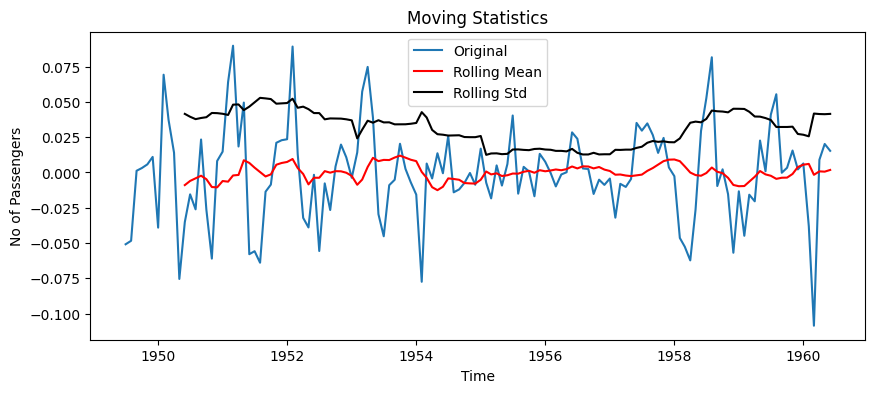

In [ ]:
# Perform stationarity check on the seasonal decomposed data
log_data_decomposed = residual
log_data_decomposed.dropna(inplace = True)
check_stationarity(log_data_decomposed)

# Data Transformation from Non-Stationary to Stationary

Checking the stationarity of the Airline Passenger Data


---



Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Fail to reject the null hypothesis. The data is non-stationary.
-------------------------------------------------------------------


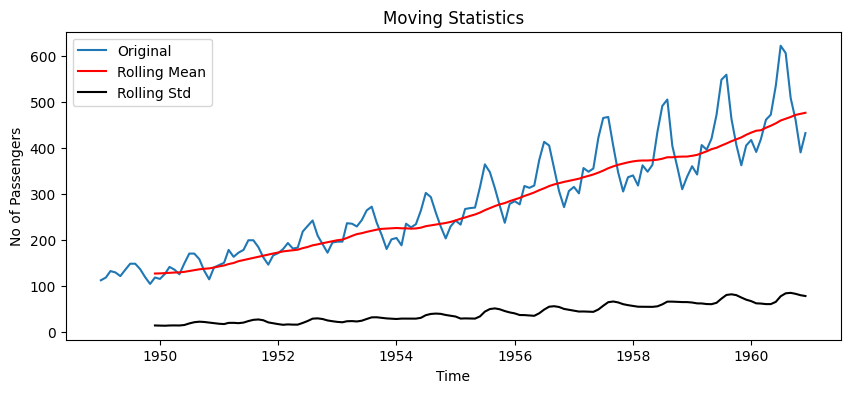

In [ ]:
check_stationarity(data['Passengers'], window_size=12, alpha=0.05)

Subtractng the adjacent log scale values of the data

---




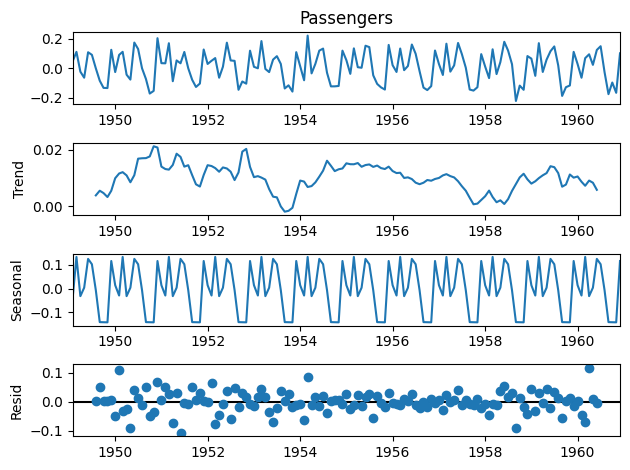

In [ ]:
log_data = np.log(data['Passengers'])
log_data_shift = log_data.diff()
log_data_shift.dropna(inplace = True)

dec = sm.tsa.seasonal_decompose(log_data_shift ,period = 12).plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
Fail to reject the null hypothesis. The data is non-stationary.
-------------------------------------------------------------------


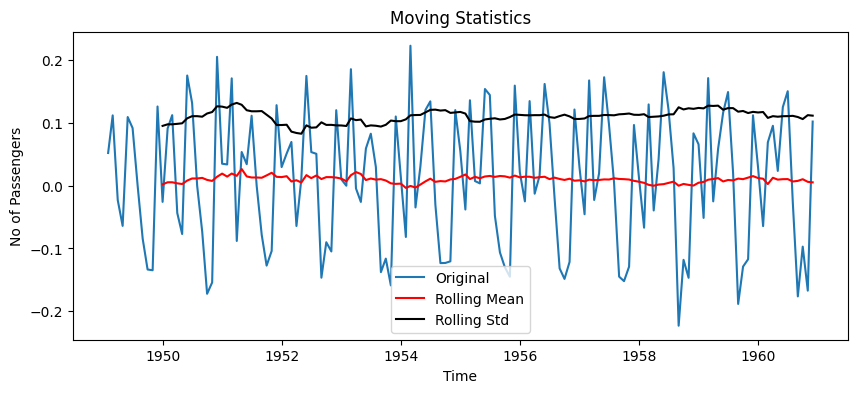

In [ ]:
check_stationarity(log_data_shift, window_size=12, alpha=0.05)

**Subtracting the adjacent values of data before log transformation**

---



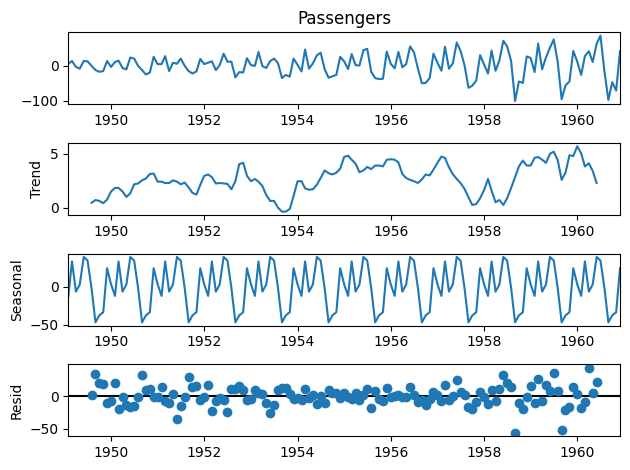

In [ ]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff['Passengers'],period = 12).plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -2.829267
p-value                          0.054213
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
Fail to reject the null hypothesis. The data is non-stationary.
-------------------------------------------------------------------


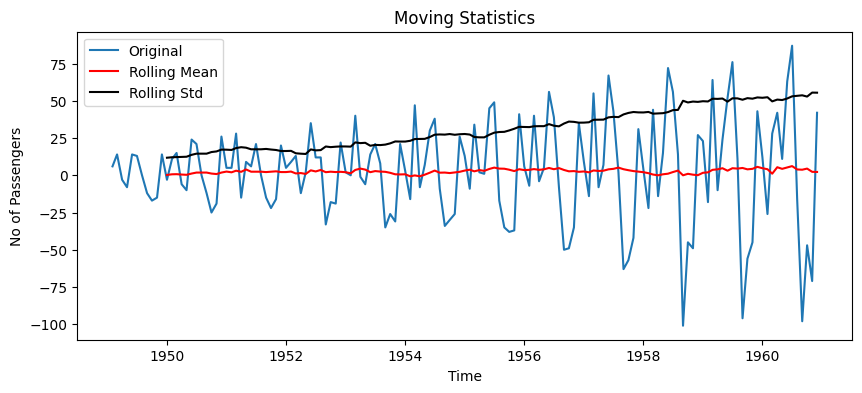

In [ ]:
check_stationarity(data_diff['Passengers'], window_size=12, alpha=0.05)

# Plotting autocorrelation and Partial autocorrelation plots

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=(10,4))
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\nDickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()


Time Series analysis plots

---



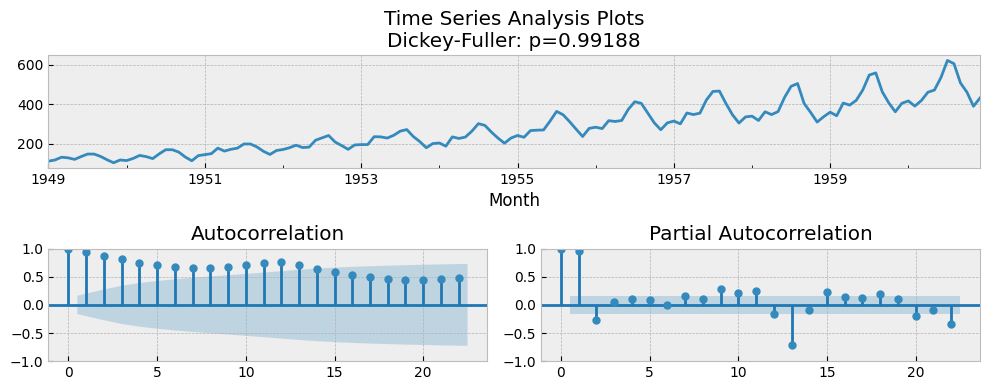

In [ ]:
tsplot(data['Passengers'])

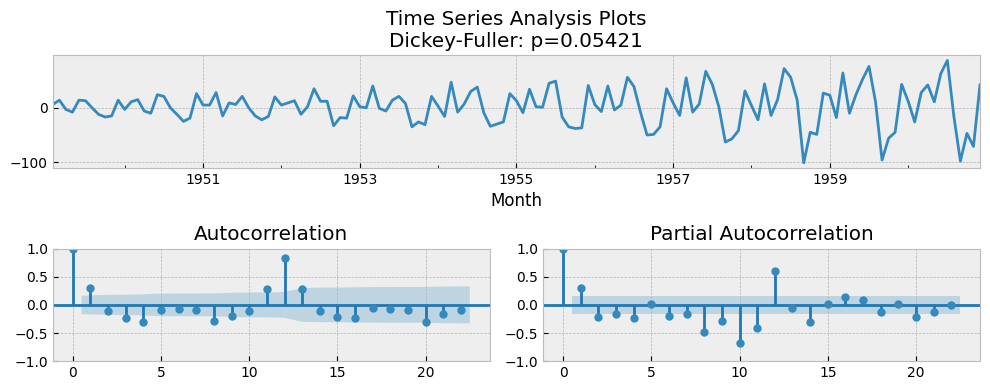

In [ ]:
tsplot(data_diff['Passengers'])

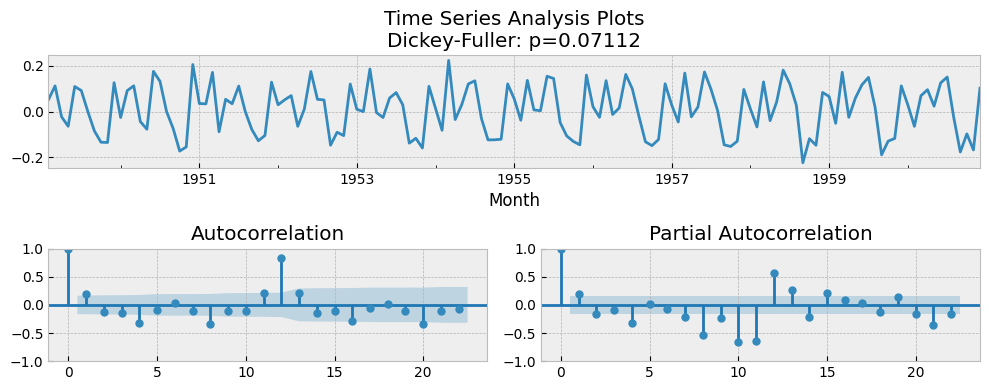

In [ ]:
tsplot(log_data_shift)

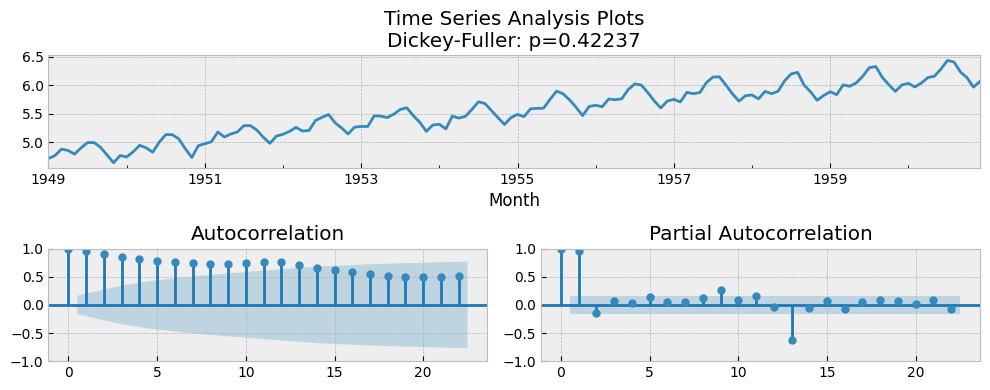

In [ ]:
tsplot(log_data)

# **ARIMA**

---



# Finding the value of d parameter in ARIMA model

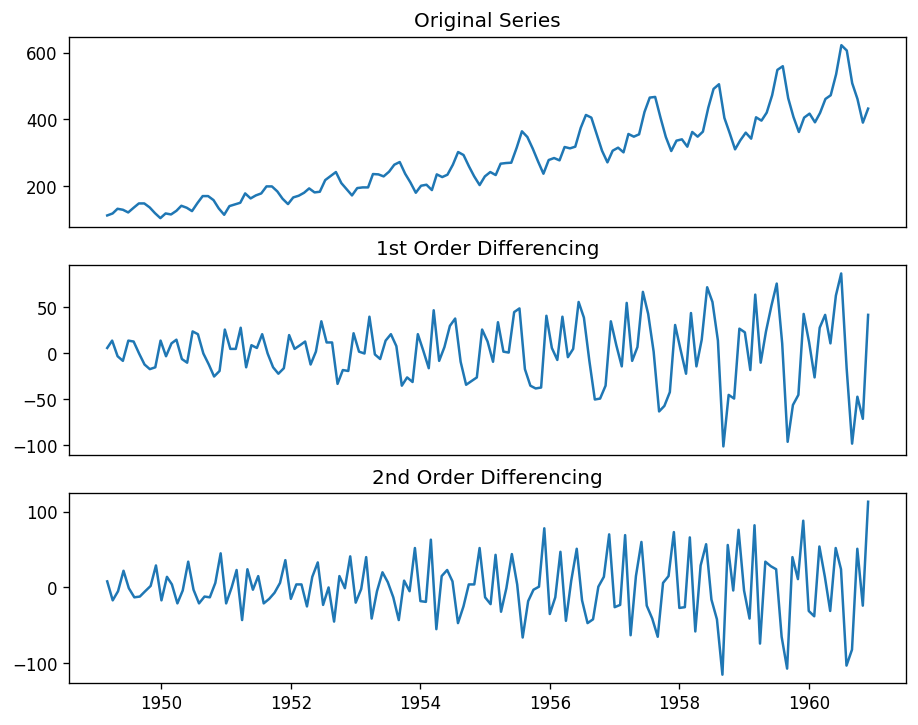

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(data.Passengers); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(data.Passengers.diff());
ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(data.Passengers.diff().diff());
ax3.set_title('2nd Order Differencing')
plt.show()

 **Autocorrelation plots for Original, first order differencing and second order differencing plots**

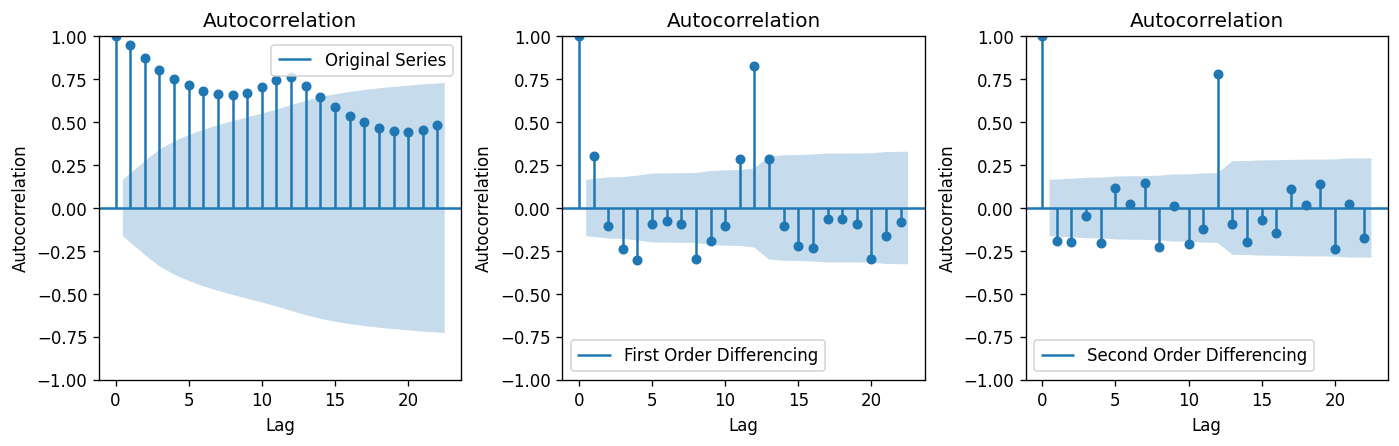

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.tight_layout(pad=3.0)

# Plot 1
axs[0].set_title('Autocorrelation (Original Series)')
plot_acf(data.Passengers, ax=axs[0])
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('Autocorrelation')
axs[0].legend(['Original Series'])

# Plot 2
axs[1].set_title('Autocorrelation (First Order Differencing)')
plot_acf(data.Passengers.diff().dropna(), ax=axs[1])
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('Autocorrelation')
axs[1].legend(['First Order Differencing'])

# Plot 3
axs[2].set_title('Autocorrelation (Second Order Differencing)')
plot_acf(data.Passengers.diff().diff().dropna(), ax=axs[2])
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelation')
axs[2].legend(['Second Order Differencing'])

plt.show()


In [ ]:
# Here we can see that in second-order differencing the immediate lag has gone
# on the negative side, representing that in the second-order the series
# has become over the difference.

# Finding the value of the parameter P

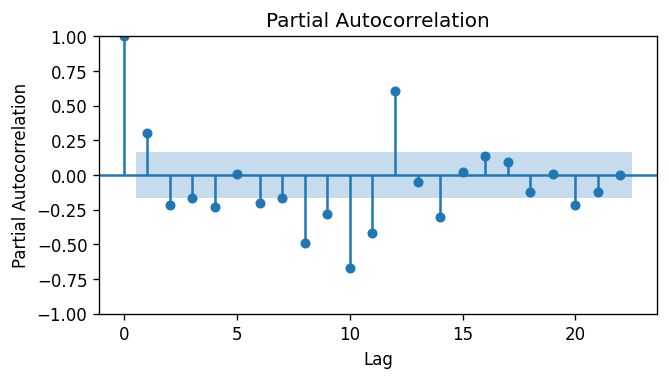

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(6, 3))

plot_pacf(data.Passengers.diff().dropna(), ax=ax)
ax.set_title('Partial Autocorrelation')
ax.set_xlabel('Lag')
ax.set_ylabel('Partial Autocorrelation')

plt.show()


In [ ]:
# Here we can see that the first lag is significantly out of the limit
# and the second one is also out of the significant limit but it is not that far
# so we can select the order of the p as 1.

# Finding the value of the parameter q

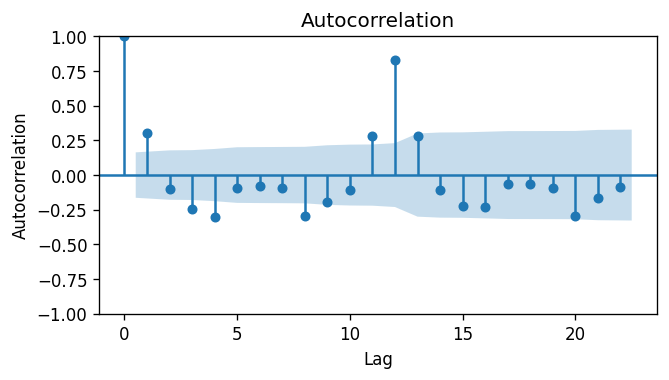

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(6, 3))

plot_acf(data.Passengers.diff().dropna(), ax=ax)
ax.set_title('Autocorrelation')
ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.show()

# Here we can see that 2 of the lags are out of the significance limit
# so we can say that the optimal value of our q (MA) is 2.

# Model Summary

In [ ]:
model = ARIMA(data['Passengers'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Tue, 18 Jul 2023   AIC                           1353.347
Time:                        05:25:00   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.061      0.000       1.645       1.725
ar.L2         -0.9549      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.845      0.0

# In-sample forcasting using ARIMA model

In [ ]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 435.368729, expected = 491.000000
predicted = 487.825559, expected = 505.000000
predicted = 484.761914, expected = 404.000000
predicted = 359.074739, expected = 359.000000
predicted = 380.902398, expected = 310.000000
predicted = 291.230227, expected = 337.000000
predicted = 336.937875, expected = 360.000000
predicted = 367.624722, expected = 342.000000
predicted = 360.295134, expected = 406.000000
predicted = 414.083702, expected = 396.000000
predicted = 378.520878, expected = 420.000000
predicted = 424.474755, expected = 472.000000
predicted = 459.477027, expected = 548.000000
predicted = 534.244080, expected = 559.000000
predicted = 523.516869, expected = 463.000000
predicted = 417.605516, expected = 407.000000
predicted = 366.683909, expected = 362.000000
predicted = 339.217575, expected = 405.000000
predicted = 411.312454, expected = 417.000000
predicted = 435.937844, expected = 391.000000
predicted = 418.796173, expected = 419.

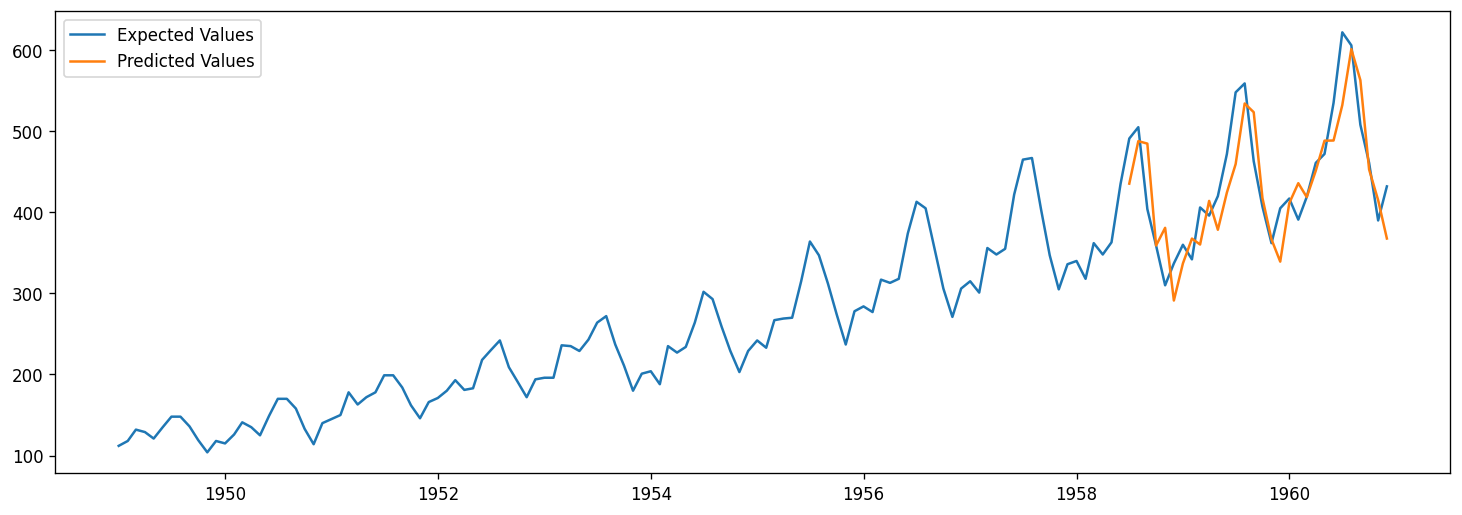

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Error
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 45.3502


# Out-of Sample Forecasting

In [ ]:
!pip install pmdarima --quiet
import pmdarima as pm
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(data['Passengers'],
                      start_p=1,
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

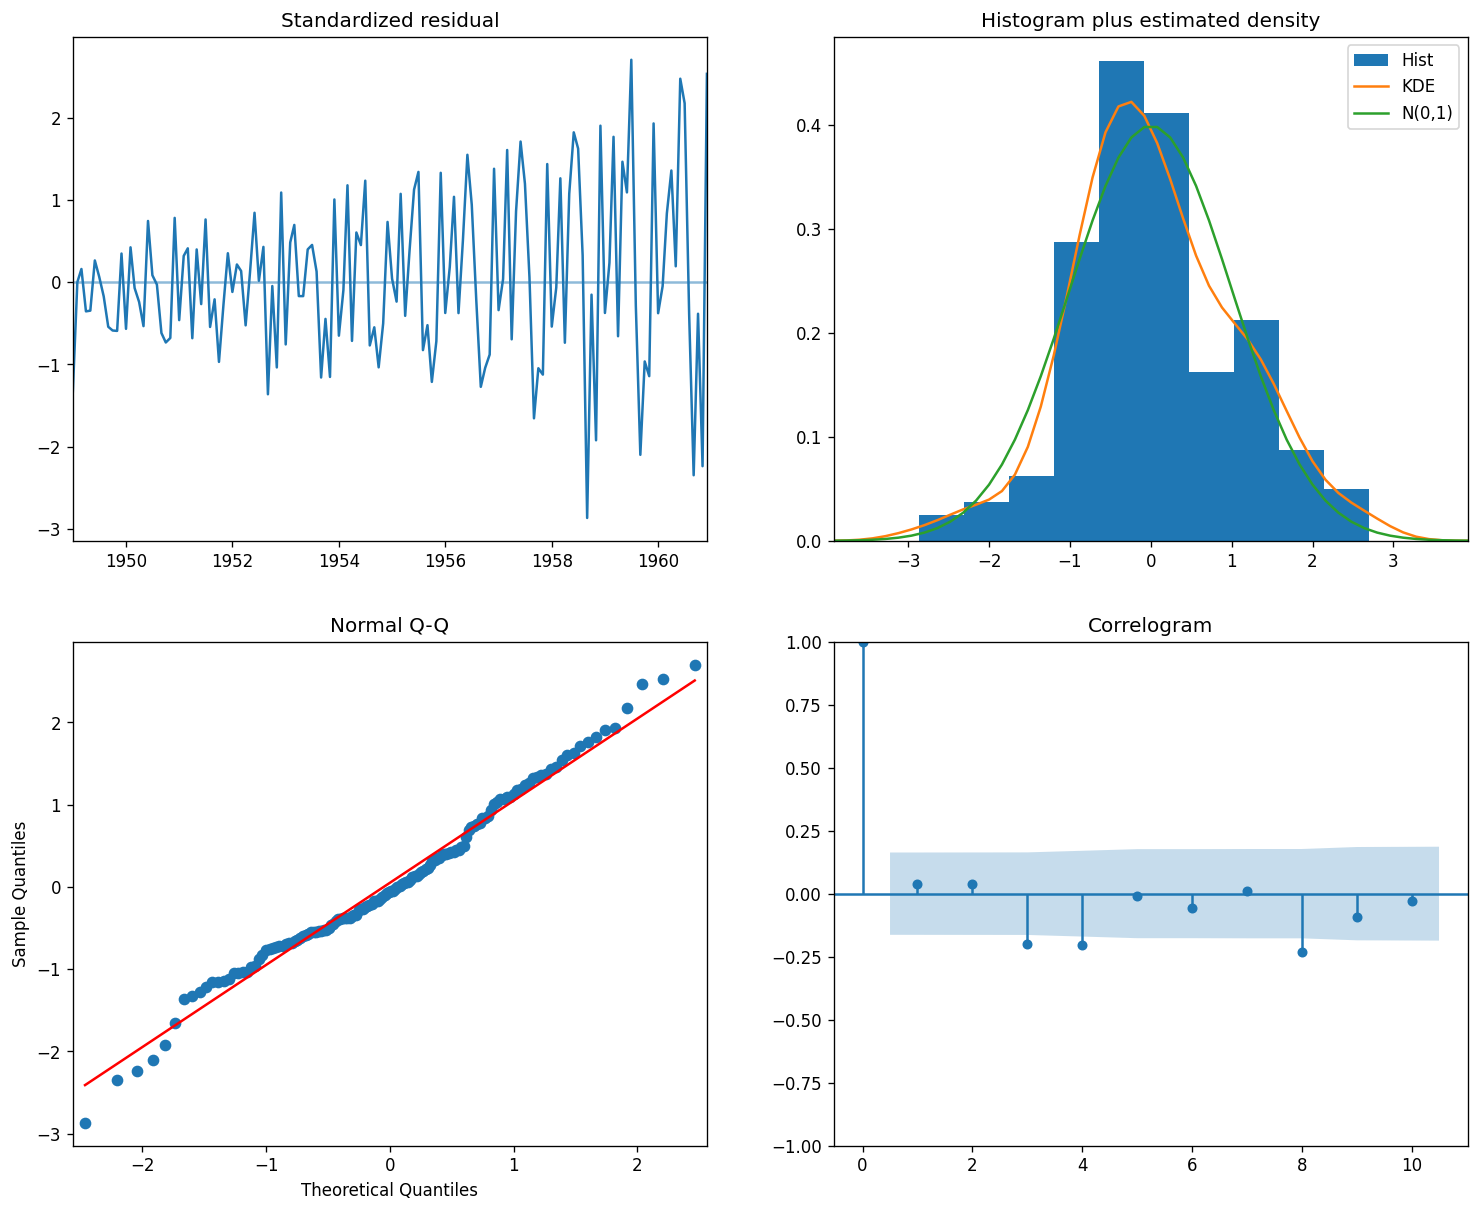

In [ ]:

ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

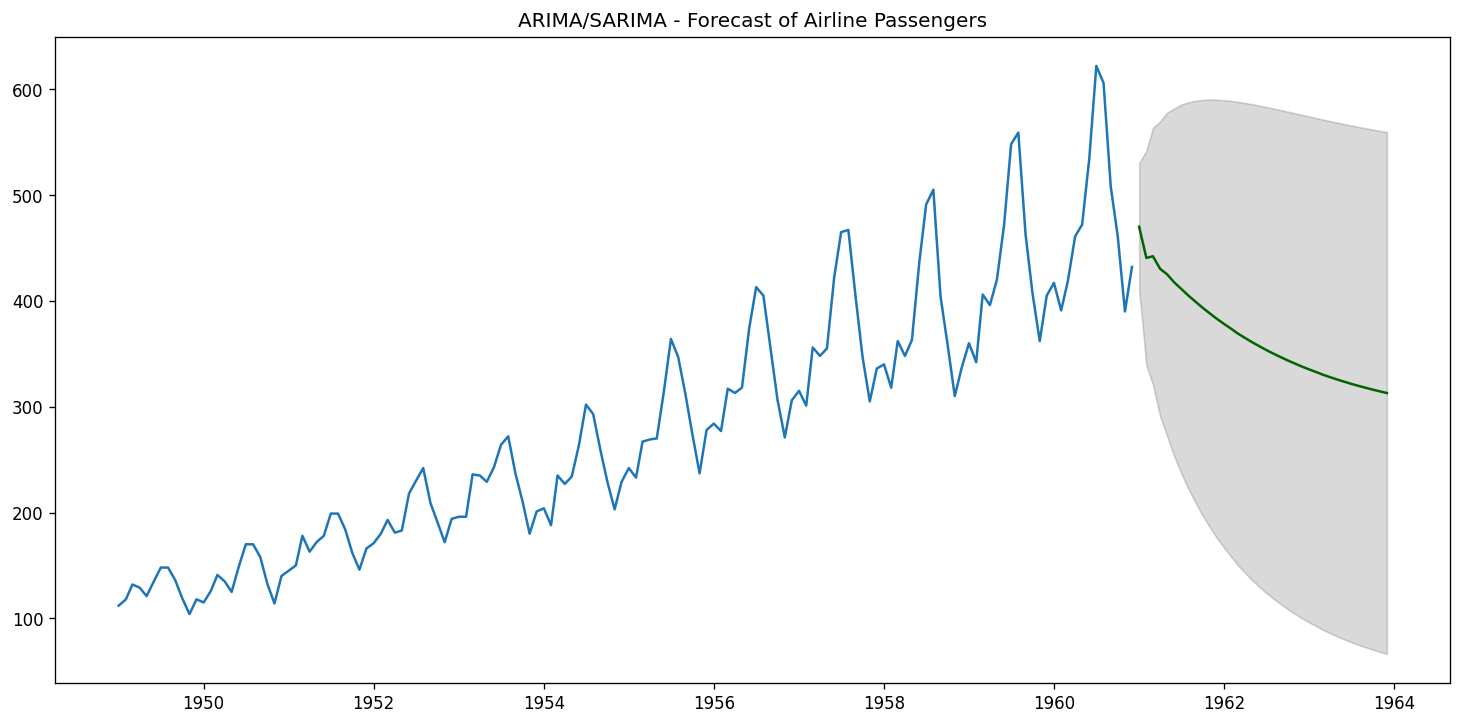

In [ ]:
def forecast(ARIMA_model, periods=36):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data["Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("ARIMA/SARIMA - Forecast of Airline Passengers")
    plt.show()

forecast(ARIMA_model)

# **SARIMA MODEL**

---



# Differencing the values of the differenced dataset with a lag of 12 and checking its statonarity

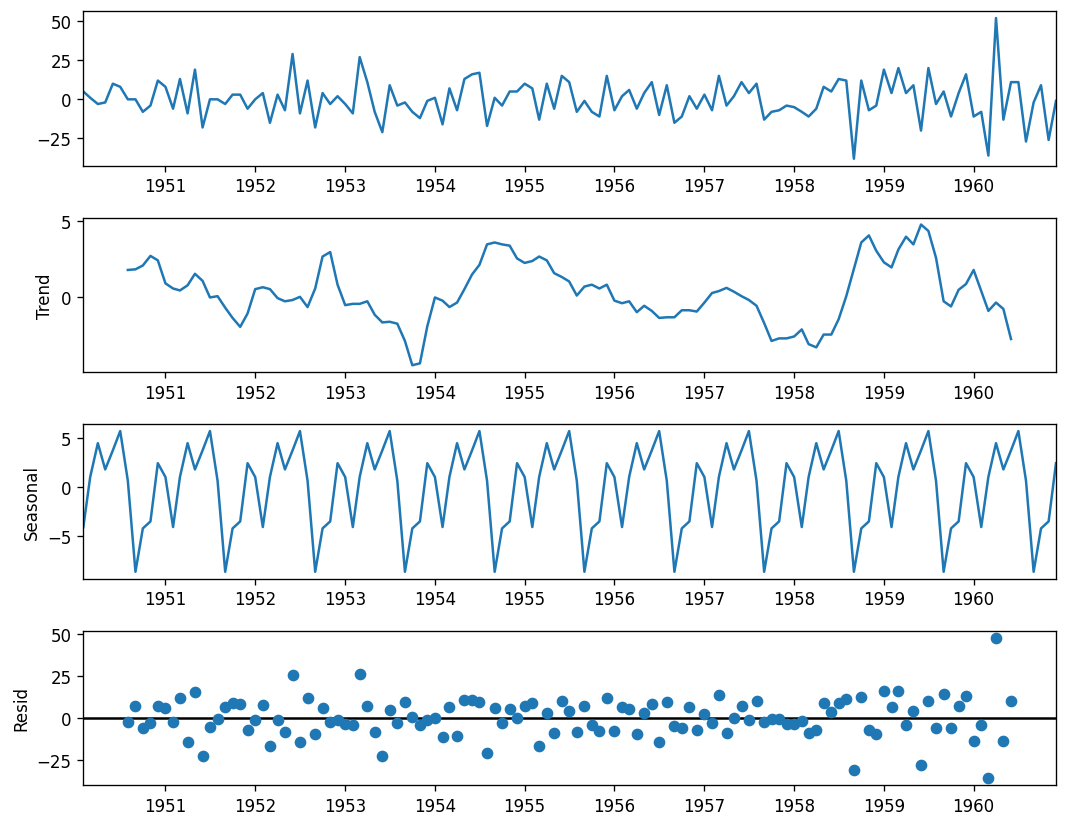

In [ ]:
data_diff_seas = data_diff.diff(12)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 12)
dec.plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


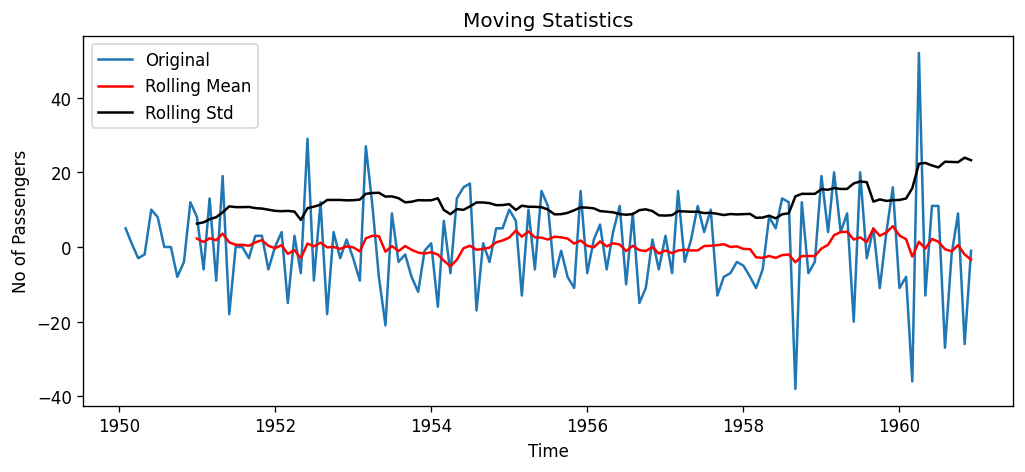

In [ ]:
check_stationarity(data_diff_seas['Passengers'])

Partial autocorrelation and autocorrelation plots for the same

---



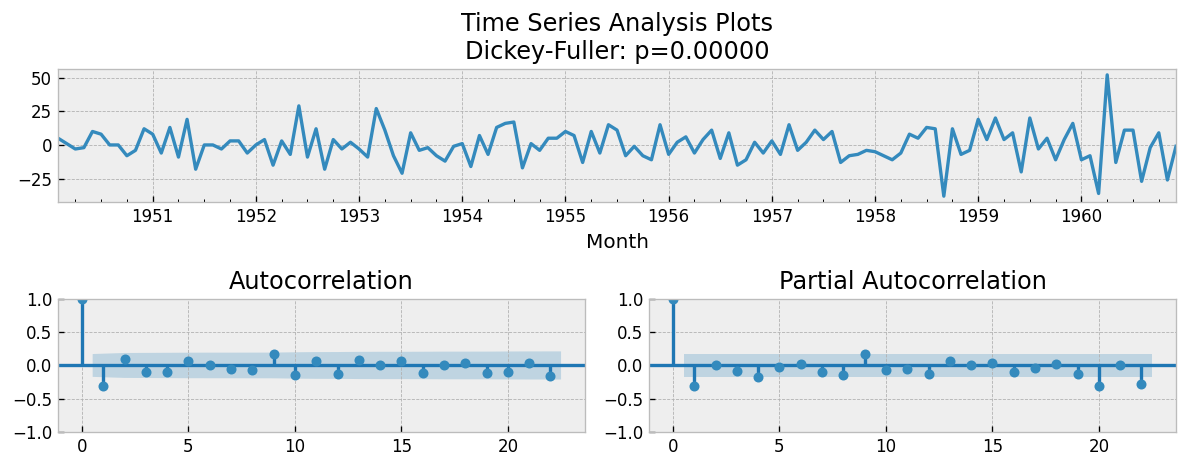

In [ ]:
tsplot(data_diff_seas['Passengers'])

# Differencing the values of differenced log dataset with lag of 12 and checking its stationarity

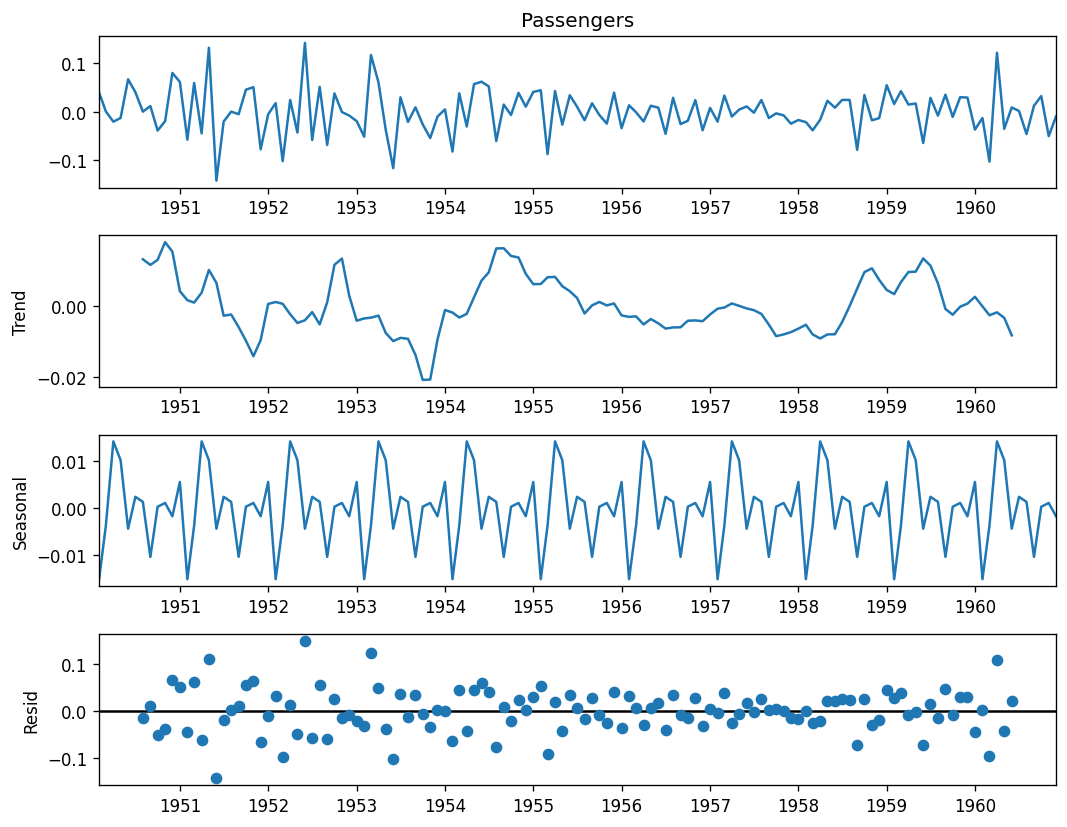

In [ ]:
log_data_diff_seas = log_data_shift.diff(12)
log_data_diff_seas = log_data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(log_data_diff_seas ,period = 12)
dec.plot()
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
Reject the null hypothesis. The data is stationary.
------------------------------------------------------------


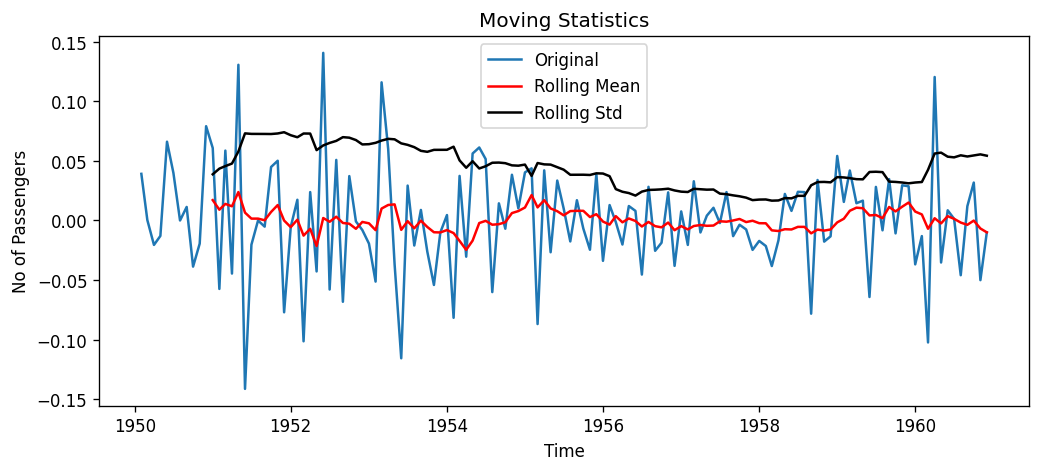

In [ ]:
check_stationarity(log_data_diff_seas)

Partial autocorrelation and autocorrelation plots for the same


---



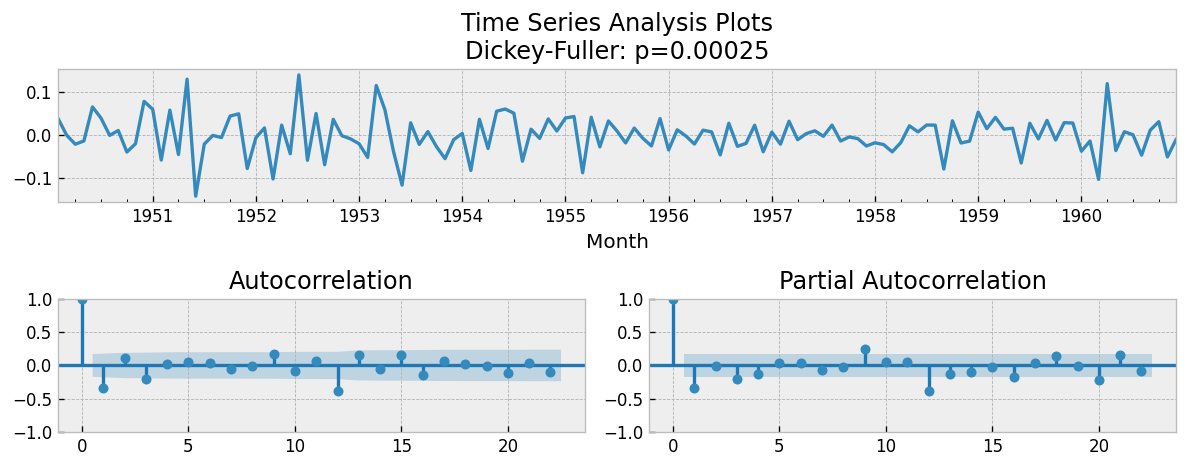

In [ ]:
tsplot(log_data_diff_seas)

In [ ]:
# For the SARIMA model, order of (p,d,q) will be same as the order of the ARIMA model above.
# For (P,D,Q,M) :
# P : 0
# D : 1
# Q : 1
# M : 12

# Model Summary

In [ ]:
model = sm.tsa.statespace.SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (0,1,1,12))
model_fit = model.fit()
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                -503.968
Date:                              Tue, 18 Jul 2023   AIC                           1019.935
Time:                                      05:25:33   BIC                           1037.186
Sample:                                  01-01-1949   HQIC                          1026.945
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3966      0.422      0.940      0.347      -0.430       1.223
ar.L2          0.35

# In-Sample Forecasting

In [ ]:
size = int(len(data) - 30)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

print('\t SARIMA MODEL : In - Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = sm.tsa.statespace.SARIMAX(history,order = (2,1,2),seasonal_order = (0,1,1,12))
    model_fit = model.fit()

    output = model_fit.forecast()

    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    print('predicted = %f, expected = %f' % (yhat, obs))

	 SARIMA MODEL : In - Sample Forecasting 

predicted = 479.085765, expected = 491.000000
predicted = 490.553509, expected = 505.000000
predicted = 441.276125, expected = 404.000000
predicted = 357.274099, expected = 359.000000
predicted = 315.250484, expected = 310.000000
predicted = 347.831879, expected = 337.000000
predicted = 344.251448, expected = 360.000000
predicted = 336.839209, expected = 342.000000
predicted = 387.593116, expected = 406.000000
predicted = 387.333485, expected = 396.000000
predicted = 408.192789, expected = 420.000000
predicted = 485.988165, expected = 472.000000
predicted = 529.031343, expected = 548.000000
predicted = 551.914006, expected = 559.000000
predicted = 459.061270, expected = 463.000000
predicted = 411.970100, expected = 407.000000
predicted = 358.421153, expected = 362.000000
predicted = 384.945724, expected = 405.000000
predicted = 420.144085, expected = 417.000000
predicted = 397.755393, expected = 391.000000
predicted = 451.335502, expected = 41

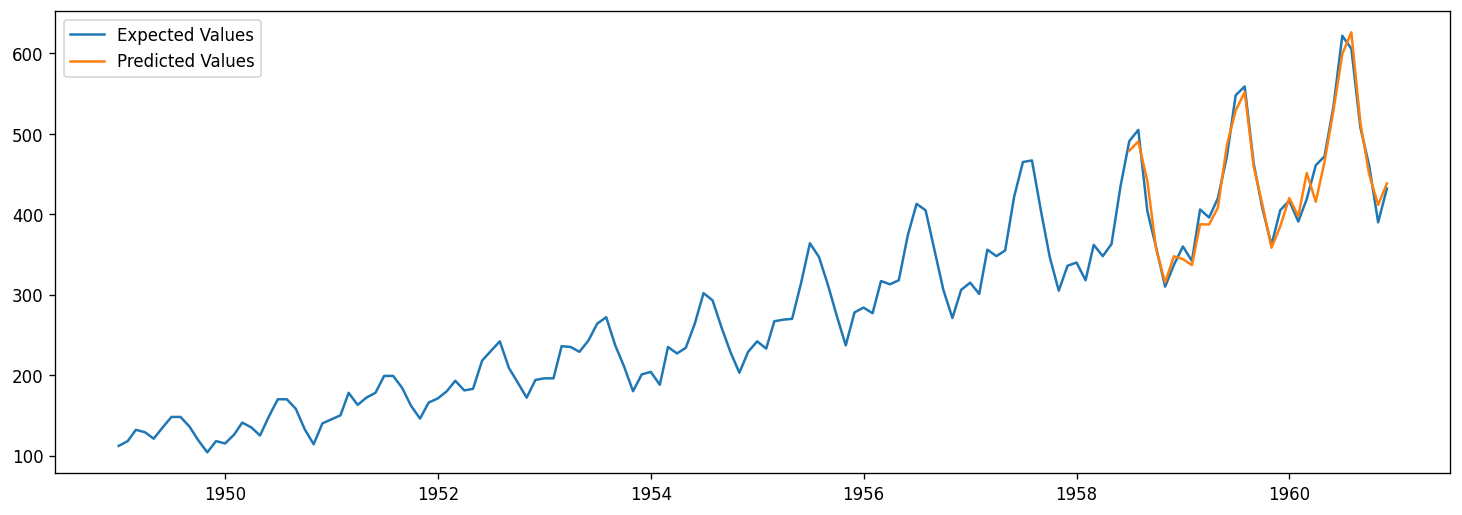

In [ ]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['Passengers'],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [ ]:
error = np.sqrt(mean_squared_error(test,predictions))
print('Test RMSE: %.4f' % error)

Test RMSE: 16.9251


# Out of Sample Forecasting

In [ ]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model = pm.auto_arima(data["Passengers"], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3,
                         m=12, #12 is the frequncy of the cycle
                         start_P=0,
                         seasonal=True, #set to seasonal
                         d=None,
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

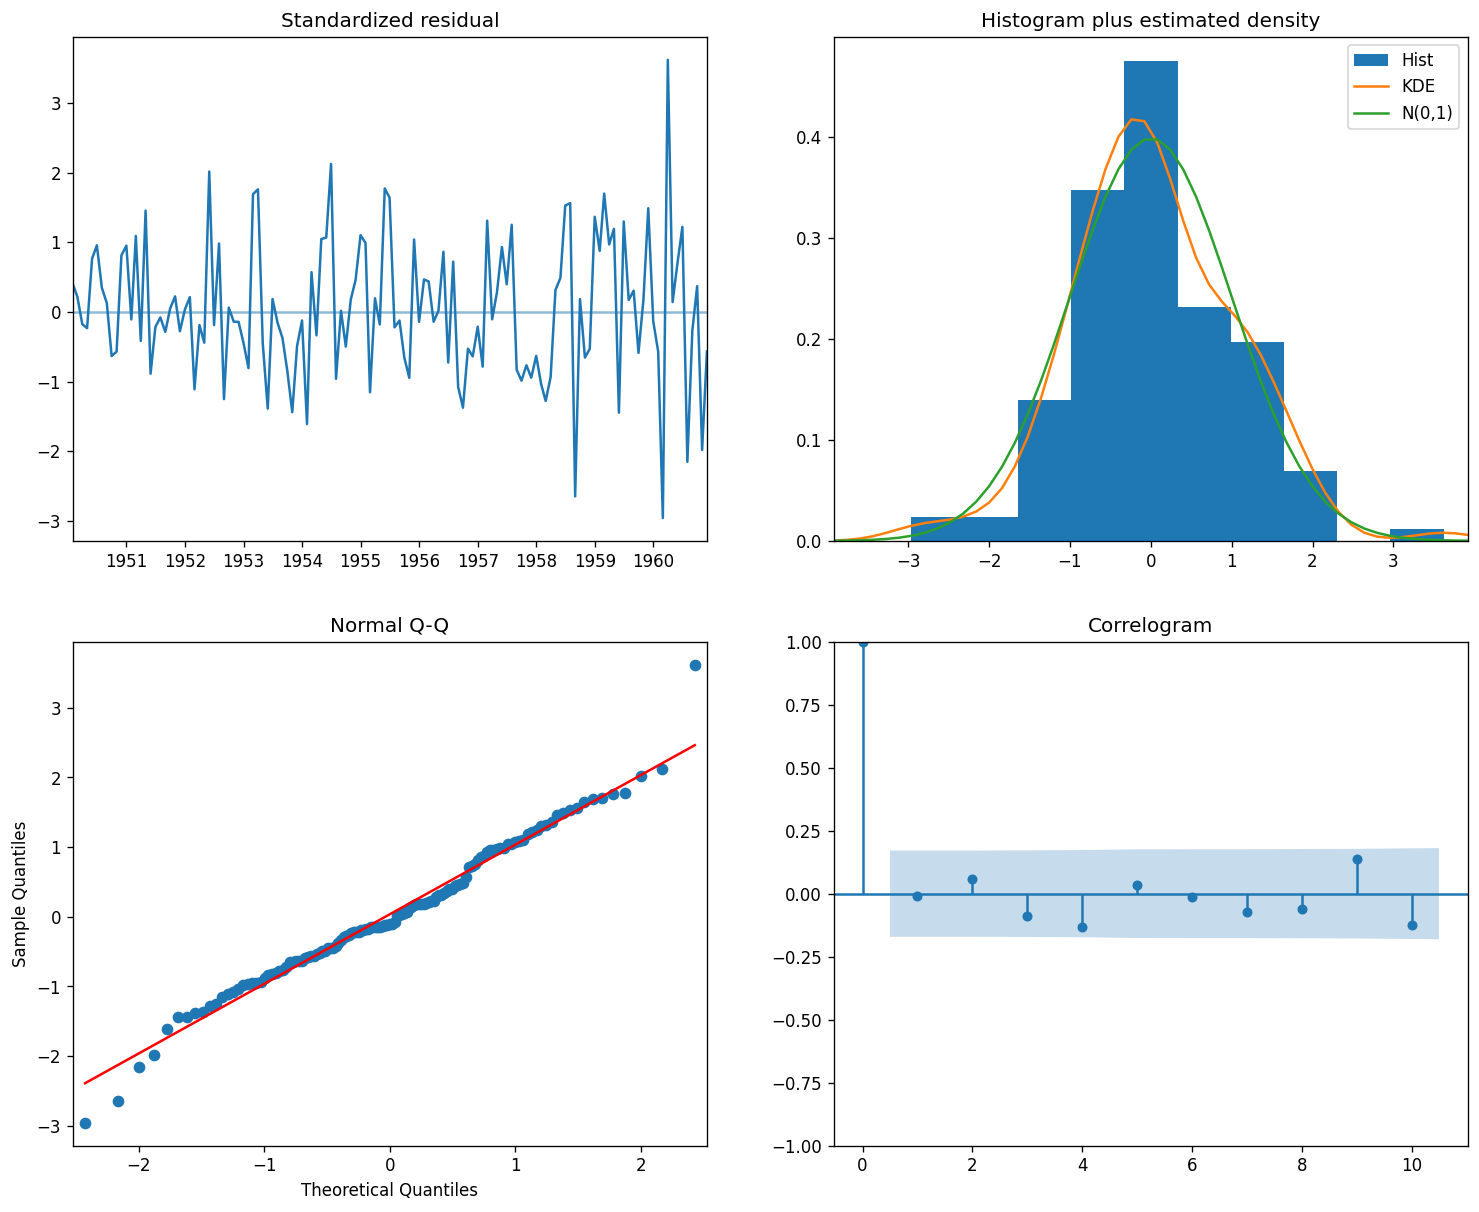

In [ ]:
SARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

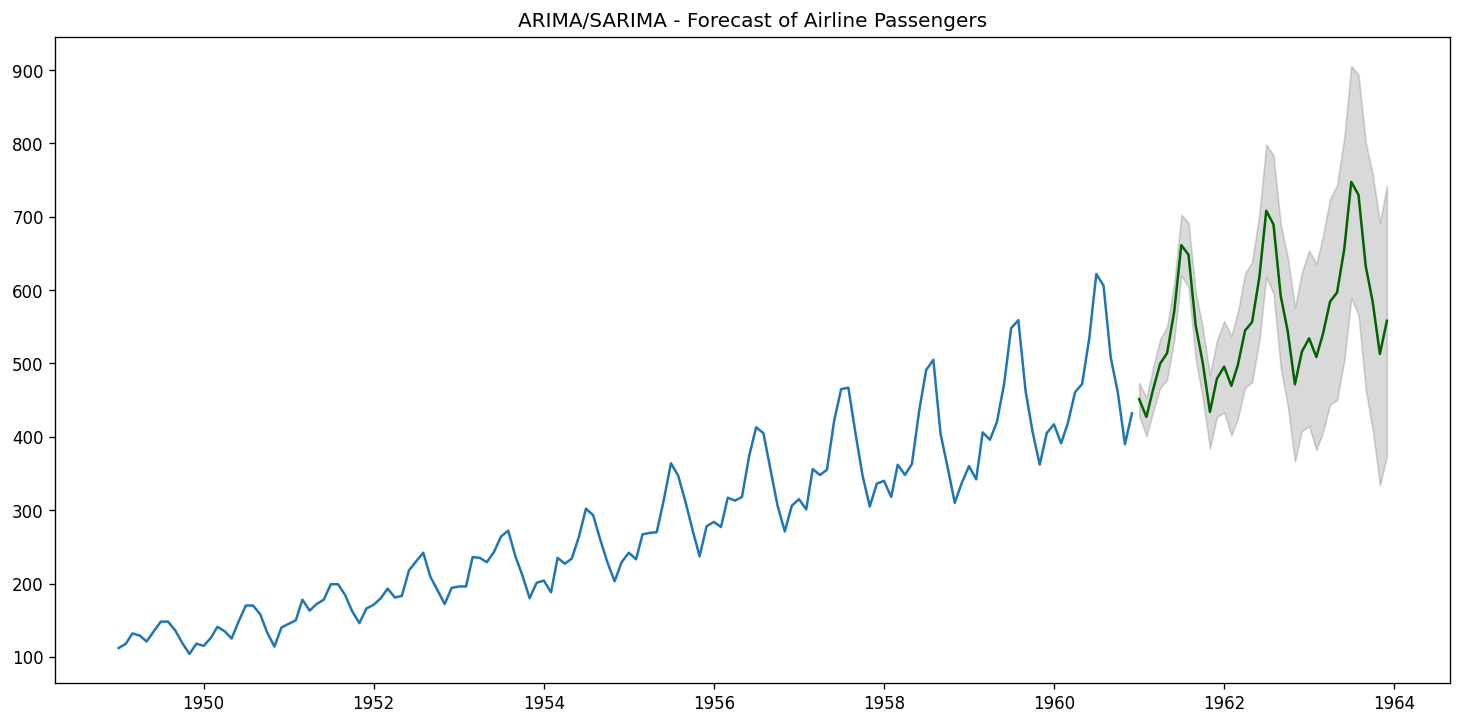

In [ ]:
forecast(SARIMA_model)

# **SARIMX MODEL**

In [ ]:
#adding exogenous variable
data['Month'] = data.index.month

# SARIMAX Model
SARIMAX_model = pm.auto_arima(data[['Passengers']], exogenous=data[['Month']],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

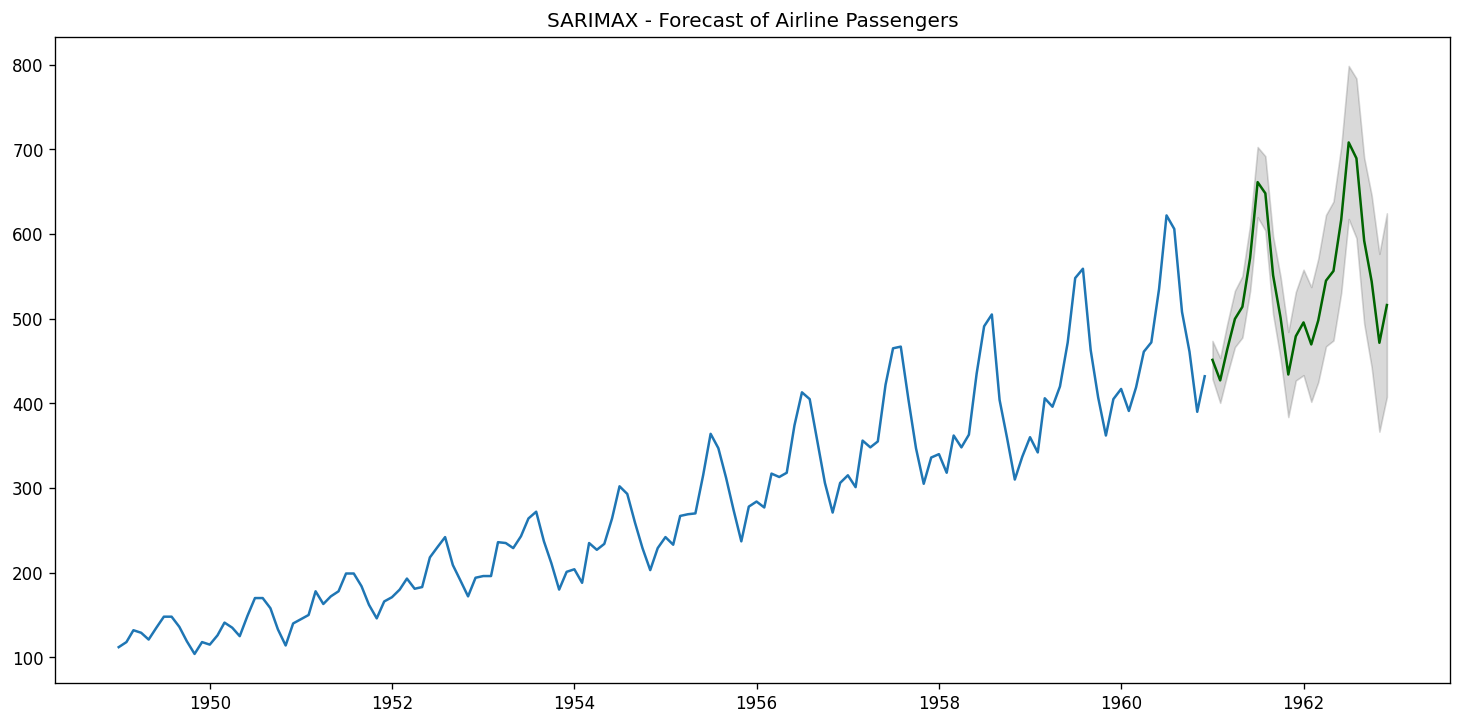

In [ ]:
def sarimax_forecast(SARIMAX_model, periods=24):
    # Forecast
    n_periods = periods

    forecast_data = pd.DataFrame({"month_index":pd.date_range(data.index[-1], periods = n_periods, freq='MS').month},
                    index = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS'))

    fitted, confint = SARIMAX_model.predict(n_periods=n_periods,
                                            return_conf_int=True,
                                            exogenous=forecast_data[['month_index']])
    index_of_fc = pd.date_range(data.index[-1] + pd.DateOffset(months=1), periods = n_periods, freq='MS')

    # make series for plotting purpose
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(15,7))
    plt.plot(data["Passengers"], color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index,
                    lower_series,
                    upper_series,
                    color='k', alpha=.15)

    plt.title("SARIMAX - Forecast of Airline Passengers")
    plt.show()

sarimax_forecast(SARIMAX_model, periods=24)

# **PSO**

In [ ]:
!pip install pyswarm --quiet
import numpy as np
import pmdarima as pm
from pyswarm import pso
import pandas as pd
import matplotlib.pyplot as plt


  Preparing metadata (setup.py) ... done


In [ ]:
def arima_obj(params, data):
    p, d, q = params
    try:
        model = pm.ARIMA(order=(p, d, q))
        model.fit(data)
        return model.aic()
    except:
        return np.inf


In [ ]:
# arima_obj((2, 1, 2), data)

In [ ]:
lb = [1, 0, 1]  # Lower bounds for p, d, q
ub = [3, 2, 3]  # Upper bounds for p, d, q
bounds = (lb, ub)


In [ ]:
def optimize_arima(data):
    # Define the objective function for PSO
    obj_func = lambda x: arima_obj(x, data)

    # Run PSO optimization
    result = pso(obj_func, lb, ub, swarmsize=10, maxiter=100)

    # Extract the optimized parameters
    p, d, q = result[0]
    print(p)
    print(d)
    print(q)
    return int(p), int(d), int(q)


In [ ]:
optimize_arima(data)

Stopping search: maximum iterations reached --> 100
2.07407770214905
1.5455414057173307
1.9874469408430104


(2, 1, 1)

In [ ]:
def forecast_optimized(data, periods=60):
    # data_values = data.values  # Extract the 'Passengers' column as a 1D array
    p, d, q = optimize_arima(data)
    model = pm.ARIMA(order=(p, d, q))
    model.fit(data)
    n_periods = periods
    fitted, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    last_date = data.index[-1]
    index_of_fc = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=n_periods, freq='MS')
    fitted_series = pd.Series(fitted, index=index_of_fc)
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)
    plt.figure(figsize=(15, 7))
    plt.plot(data, color='#1f76b4')
    plt.plot(fitted_series, color='darkgreen')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title("ARIMA/SARIMA - Optimized Forecast of Airline Passengers")
    plt.show()

Stopping search: maximum iterations reached --> 100
2.083554480366175
1.6957244138127638
2.1214594861059393


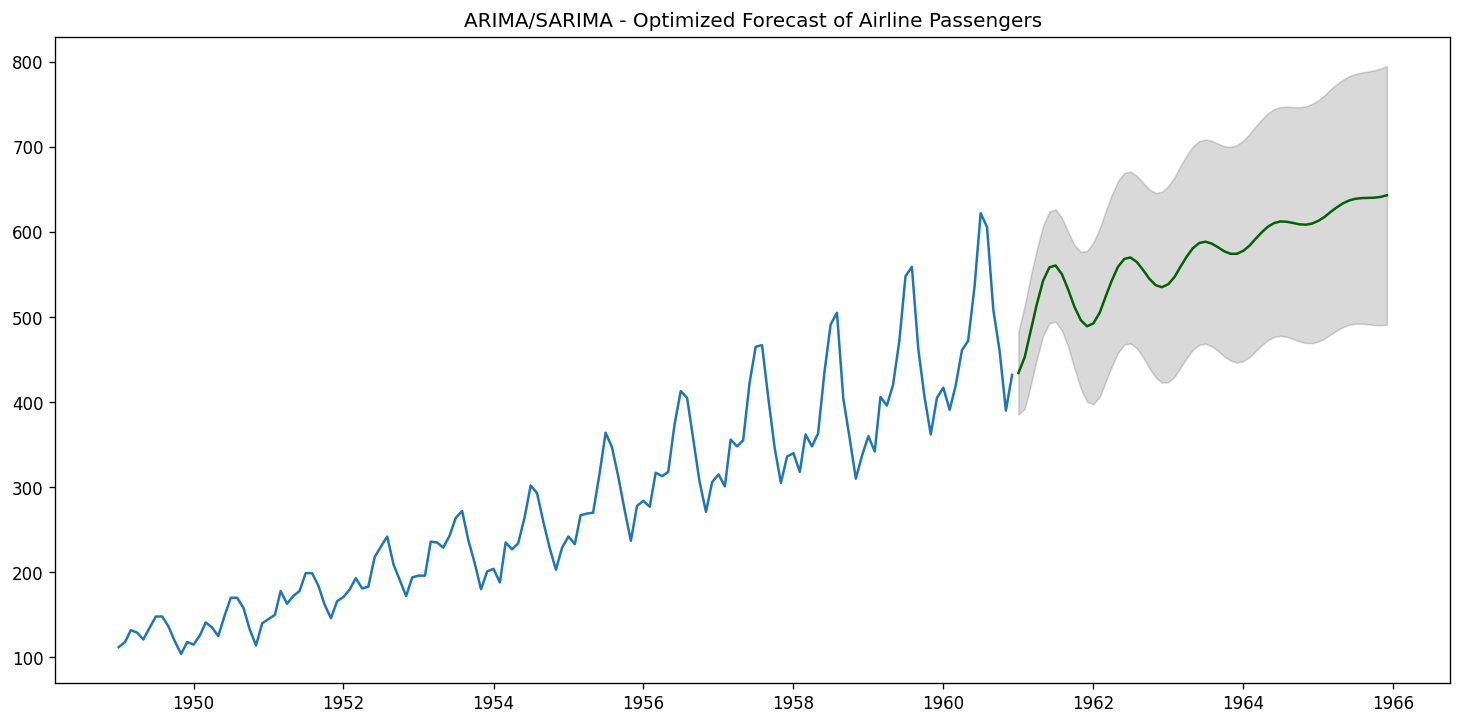

In [ ]:
forecast_optimized(data)

# PSO Trained neural network with 1 hidden layer

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from pyswarm import pso

# Load the dataset
data = pd.read_csv('/content/AirPassengers.csv')

# Preprocess the data
data['Month'] = pd.to_datetime(data['Month'])
data = data.set_index('Month')

# Define the PSO-based neural network model
def nn_model(params, X):
    # Set the model parameters
    hidden_size = int(params[0])
    learning_rate = params[1]
    momentum = params[2]

    # Initialize the neural network model
    model = MLPRegressor(hidden_layer_sizes=(hidden_size,),
                         learning_rate_init=learning_rate,
                         momentum=momentum,
                         random_state=42)

    # Train the model
    model.fit(X, y)

    # Predict the values
    y_pred = model.predict(X)

    # Return the predicted values
    return y_pred

# Define the objective function for PSO
def objective_function(params, *args):
    X, y = args
    y_pred = nn_model(params, X)
    mse = np.mean((y_pred - y) ** 2)
    return mse

# Split the data into input (X) and target (y) variables
X = np.arange(len(data)).reshape(-1, 1)
y = data.values

# # Define the bounds for PSO optimization
# bounds = [(1, 50),  # Hidden layer size
#           (0.001, 0.1),  # Learning rate
#           (0.1, 0.9)]  # Momentum

# Perform PSO optimization
lb = [1, 0.001, 0.1]
ub = [100, 0.1, 0.9]
best_params, _ = pso(objective_function, lb, ub, args=(X, y), maxiter=100)




Stopping search: Swarm best position change less than 1e-08


In [ ]:
print(best_params)

[11.57450536  0.09568557  0.64708046]


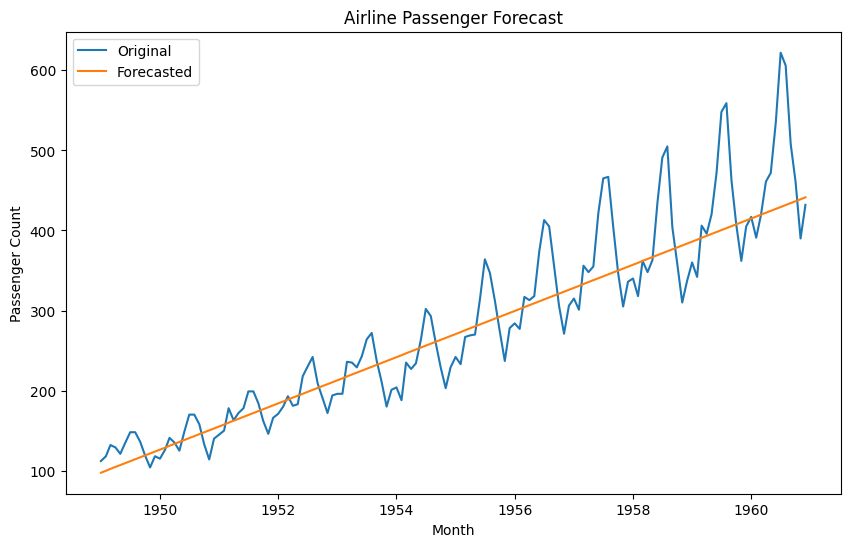

In [ ]:
# Train the final model with the best parameters
y_pred = nn_model(best_params, X)

# Plot the original and forecasted time series
plt.figure(figsize=(10, 6))
plt.plot(data.index, y, label='Original')
plt.plot(data.index, y_pred, label='Forecasted')
plt.xlabel('Month')
plt.ylabel('Passenger Count')
plt.title('Airline Passenger Forecast')
plt.legend()
plt.show()

# PSO trained neural network with 2 hidden layers

In [ ]:
# Define the PSO-based neural network model
def nn_model(params, X):
    # Set the model parameters
    hidden_size1 = int(params[0])
    hidden_size2 = int(params[1])
    learning_rate = params[2]
    momentum = params[3]

    # Initialize the neural network model
    model = MLPRegressor(hidden_layer_sizes=(hidden_size1, hidden_size2),
                         activation = 'relu',
                         learning_rate_init=learning_rate,
                         momentum=momentum,
                         random_state=42)

    # Train the model
    model.fit(X, y)

    # Predict the values
    y_pred = model.predict(X)

    # Return the predicted values
    return y_pred

# Define the objective function for PSO
def objective_function(params, *args):
    X, y = args
    y_pred = nn_model(params, X)
    mse = np.mean((y_pred - y) ** 2)
    return mse

# Split the data into input (X) and target (y) variables
X = np.arange(len(data)).reshape(-1, 1)
y = data.values

# Perform PSO optimization
lb = [1, 1, 0.001, 0.1]
ub = [100, 100, 0.1, 0.9]
best_params, _ = pso(objective_function, lb, ub, args=(X, y), maxiter=100)

Stopping search: maximum iterations reached --> 100


In [ ]:
print(best_params)

[8.21460942e+01 8.93968421e+01 7.77619718e-02 3.11151471e-01]


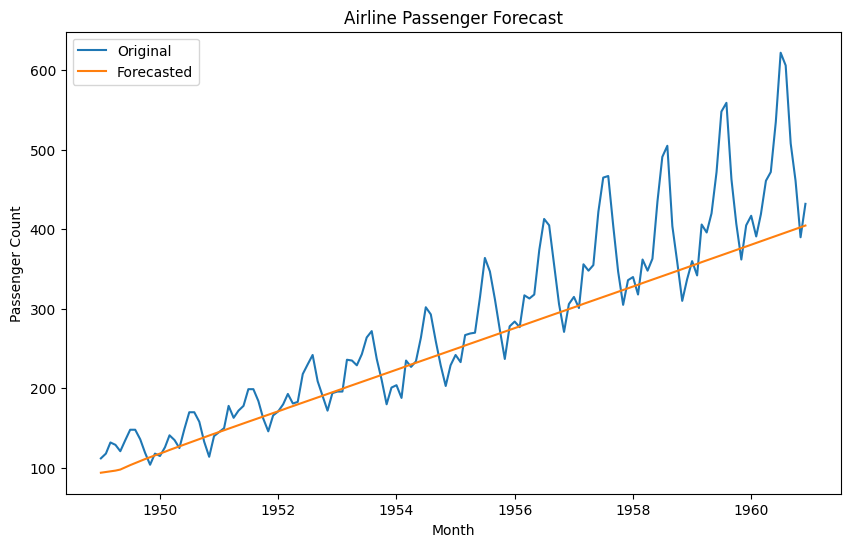

In [ ]:
# Train the final model with the best parameters
y_pred = nn_model(best_params, X)

# Plot the original and forecasted time series
plt.figure(figsize=(10, 6))
plt.plot(data.index, y, label='Original')
plt.plot(data.index, y_pred, label='Forecasted')
plt.xlabel('Month')
plt.ylabel('Passenger Count')
plt.title('Airline Passenger Forecast')
plt.legend()
plt.show()